# Preprocessing
In this notebook a preprocessing of the images to assure a better quaility and results in the process will be undertaken. First step as always will be importing the correponding libraries.

In [1]:
import pandas as pd
import numpy as np
import glob2
import os
from skimage import io
from skimage import color
from skimage.filters import difference_of_gaussians
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE
import albumentations as A

## Labels loading
Reading, organizing and corretly labelling the cases is needed before any preprocessing. The original dataset contains multiple information but for the sake of our project we will only select the relevant information, thisn being: File Name, Bi-Rads, Laterallity and View. 
+ File Name: 
+ Bi-Rads : 
+ Laterality:  
+ View: 

In [2]:
df_INbreast = pd.read_csv('C:/Users/bigdata/Desktop/TFG/data/INbreast.csv', sep = ',', usecols = ['File Name', 'Bi-Rads', 'Laterality', 'View', 'Acquisition date'])

print(df_INbreast['Bi-Rads'])
# Define your mapping dictionary
nuevo_birads = {'0': 'incompleto', '1': 'benigno', '2': 'benigno', '3': 'seguimiento', '4': 'maligno', '5': 'maligno', '6': 'maligno'}

# Finally, map the integer values to your desired categories
df_INbreast['Bi-Rads'] = df_INbreast['Bi-Rads'].astype(str).map(nuevo_birads).astype('category')
df_INbreast.head(20)


0      1
1      3
2      1
3      3
4      5
      ..
405    1
406    2
407    2
408    2
409    2
Name: Bi-Rads, Length: 410, dtype: int64


,Laterality,View,Acquisition date,File Name,Bi-Rads
0,R,CC,201001,22678622,benigno
1,L,CC,201001,22678646,seguimiento
2,R,MLO,201001,22678670,benigno
3,L,MLO,201001,22678694,seguimiento
4,R,CC,201001,22614074,maligno
5,L,CC,201001,22614097,benigno
6,R,MLO,201001,22614127,maligno
7,L,MLO,201001,22614150,benigno
8,L,MLO,201001,50997434,benigno
9,R,MLO,201001,50997461,maligno


<Axes: >

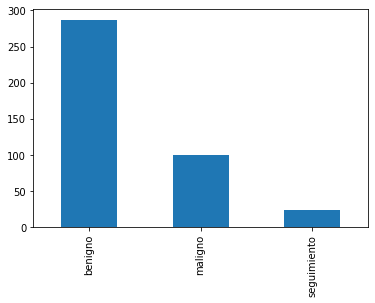

In [3]:
df_INbreast['Bi-Rads'].value_counts().plot(kind='bar')

## Loading the files path
Listamos todos los ficheros de mamogradias y los incorporamos al dataframe. Aprovechamos la información del fichero para identificar los diferentes casos (seguún paciente y lateralidad)

In [4]:
ruta_img = 'C:/Users/bigdata/Desktop/TFG/data/ALL-IMGS/'
filepaths = pd.DataFrame([os.path.basename(x) for x in glob2.glob(ruta_img + '*.dcm')], columns = ['File Path'])
filepaths['File Name'] = ''
filepaths['Case ID'] = ''
for idx, row in filepaths.iterrows():
    filepaths['File Name'][idx] = int(row['File Path'].split('_')[0])
    filepaths['Case ID'][idx] = row['File Path'].split('_')[1]

df_INbreast = df_INbreast.merge(filepaths, on = 'File Name').drop(columns = ['File Name'])
df_INbreast['Case ID'] = df_INbreast['Case ID'] + '_' + df_INbreast['Acquisition date'].astype(str) + '_' + df_INbreast['Laterality'] + '_' + df_INbreast['Bi-Rads'].astype(str)
df_INbreast = df_INbreast.drop(columns = ['Acquisition date', 'Laterality'])
df_INbreast.head()

,View,Bi-Rads,File Path,Case ID
0,CC,benigno,22678622_61b13c59bcba149e_MG_R_CC_ANON.dcm,61b13c59bcba149e_201001_R_benigno
1,CC,seguimiento,22678646_61b13c59bcba149e_MG_L_CC_ANON.dcm,61b13c59bcba149e_201001_L_seguimiento
2,MLO,benigno,22678670_61b13c59bcba149e_MG_R_ML_ANON.dcm,61b13c59bcba149e_201001_R_benigno
3,MLO,seguimiento,22678694_61b13c59bcba149e_MG_L_ML_ANON.dcm,61b13c59bcba149e_201001_L_seguimiento
4,CC,maligno,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON.dcm,6bd24a0a42c19ce1_201001_R_maligno


Now we will delete the cases that dont have the cc and mlo view

In [5]:
one_hot_view = pd.get_dummies(df_INbreast['View'])
df_INbreast = df_INbreast.drop(columns = ['View']).join(one_hot_view)
df_INbreast = df_INbreast[df_INbreast['FB'] != 1].drop(columns = ['FB'])
anom_id = pd.pivot_table(df_INbreast, index = ['Case ID'], values=['CC','MLO'], aggfunc = np.sum)
anom_id = anom_id[anom_id['CC'] + anom_id['MLO'] != 2]
df_INbreast = df_INbreast[~df_INbreast['Case ID'].isin(anom_id.index)]
df_INbreast.shape

(402, 5)

In [6]:
df_INbreast.head()

,Bi-Rads,File Path,Case ID,CC,MLO
0,benigno,22678622_61b13c59bcba149e_MG_R_CC_ANON.dcm,61b13c59bcba149e_201001_R_benigno,1,0
1,seguimiento,22678646_61b13c59bcba149e_MG_L_CC_ANON.dcm,61b13c59bcba149e_201001_L_seguimiento,1,0
2,benigno,22678670_61b13c59bcba149e_MG_R_ML_ANON.dcm,61b13c59bcba149e_201001_R_benigno,0,1
3,seguimiento,22678694_61b13c59bcba149e_MG_L_ML_ANON.dcm,61b13c59bcba149e_201001_L_seguimiento,0,1
4,maligno,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON.dcm,6bd24a0a42c19ce1_201001_R_maligno,1,0


## Loading images
Here essential functions to read the images are defined. Bascially a images will be loaded as as an array where the preprocessing functions will be applied.

In [7]:
def right_orient_mammogram(image):
    """
    Credit to:
    https://github.com/gsunit/Pectoral-Muscle-Removal-From-Mammograms

    Checks if the mammogram is right-oriented. If not, flips it horizontally
        - image is the input image
    Returns:
        - image is is the right-oriented mammogram
    """
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

def read_image(filename, size):
    """
    Loads the image from a file, forces a right orientation and resizes it
    to a fixed size x size
        - filename is the file that contains the image
    Returns: 
        - right_image is the right-oriented mammogram
    """
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_CUBIC)
    return image

def visualize(image):
    """
    Visualize the input image
        - image is the input image that wants to be represented
    """
    plt.figure(figsize = (10, 10))
    plt.axis('off')
    plt.imshow(image)
    return

def crop(img):
    """
    Credit to:
    https://towardsdatascience.com/end-to-end-breast-cancer-detection-in-python-part-1-13a1695d455

    Crop ROI from mammogram, removing the background
        - img input mammogram image that wants to be cropped
    Returns:
        - cropped_image is the cropped image
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0).astype('uint8')
    _, breast_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    cropped_image = img[y:y+h, x:x+w]

    return cropped_image

def zero_padding(img, size):
    """
    Zero padding an image to (size x size)
        - img is the input image that wants to be zero padded
        - size is the desired size for the output image
    Returns:
        - zp_image is the zero-padded image
    """
    top = round((size - img.shape[0])/2)
    bottom = size - (img.shape[0] + top)
    left = round((size - img.shape[1])/2)
    right = size - (img.shape[1] + left)

    zp_image = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, 0)
    
    return zp_image

def multi_dog(img):
    """
    Applies three Difference of Gaussians filters to the image to get a 3-channel output
        - img is the input image
    Returns:
        - dog_image is a 3-channel image with three diferent DoG filters applied
    """
    img = np.dstack((difference_of_gaussians(img, 2), difference_of_gaussians(img, 4), difference_of_gaussians(img, 8)))
    dog_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX).astype(int)
    
    return dog_image


In [8]:
size_img = 512
imgs_loaded = pd.DataFrame(columns =  ['File Path', 'Image Array'])

for img_path in df_INbreast['File Path']:
    img_array = read_image(ruta_img + img_path, size_img).astype(float)
    img_array *= 255.0 / img_array.max()
    img_array = multi_dog(zero_padding(crop(img_array), size_img))
    new_row = pd.DataFrame([[img_path, img_array]], columns=['File Path', 'Image Array'])
    imgs_loaded = pd.concat([imgs_loaded, new_row], ignore_index=True)
    
df_INbreast = df_INbreast.merge(imgs_loaded, on = 'File Path', how = 'left').drop(columns = ['File Path'])
df_INbreast.head()

C:\Users\bigdata\AppData\Local\Temp/ipykernel_26520/1130836402.py:28: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = color.rgb2gray(image)


,Bi-Rads,Case ID,CC,MLO,Image Array
0,benigno,61b13c59bcba149e_201001_R_benigno,1,0,"[[[87, 87, 87], [87, 87, 87], [87, 87, 87], [8..."
1,seguimiento,61b13c59bcba149e_201001_L_seguimiento,1,0,"[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9..."
2,benigno,61b13c59bcba149e_201001_R_benigno,0,1,"[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9..."
3,seguimiento,61b13c59bcba149e_201001_L_seguimiento,0,1,"[[[103, 103, 103], [103, 103, 103], [103, 103,..."
4,maligno,6bd24a0a42c19ce1_201001_R_maligno,1,0,"[[[96, 96, 96], [96, 96, 96], [96, 96, 96], [9..."


In [9]:
df_INbreast.shape
# visualize(df_INbreast[])

(402, 5)

Reorganizamos el dataframe para juntas las dos vistas en la misma fila

In [10]:
images_cc = df_INbreast[df_INbreast['CC'] == 1].drop(columns = ['Bi-Rads', 'CC', 'MLO']).rename(columns = {'Image Array': 'CC Image'})
images_mlo = df_INbreast[df_INbreast['MLO'] == 1].drop(columns = ['Bi-Rads', 'CC', 'MLO']).rename(columns = {'Image Array': 'MLO Image'})
df_INbreast = df_INbreast[['Bi-Rads', 'Case ID']].drop_duplicates()
df_INbreast = df_INbreast.merge(images_cc, on = 'Case ID')
df_INbreast = df_INbreast.merge(images_mlo, on = 'Case ID')
df_INbreast.shape

(201, 4)

In [11]:
df_INbreast.head()

,Bi-Rads,Case ID,CC Image,MLO Image
0,benigno,61b13c59bcba149e_201001_R_benigno,"[[[87, 87, 87], [87, 87, 87], [87, 87, 87], [8...","[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9..."
1,seguimiento,61b13c59bcba149e_201001_L_seguimiento,"[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9...","[[[103, 103, 103], [103, 103, 103], [103, 103,..."
2,maligno,6bd24a0a42c19ce1_201001_R_maligno,"[[[96, 96, 96], [96, 96, 96], [96, 96, 96], [9...","[[[100, 100, 100], [100, 100, 100], [100, 100,..."
3,benigno,6bd24a0a42c19ce1_201001_L_benigno,"[[[102, 102, 102], [102, 102, 102], [102, 102,...","[[[93, 93, 93], [93, 93, 93], [93, 93, 93], [9..."
4,benigno,97ec8cadfca70d32_201001_L_benigno,"[[[111, 111, 111], [111, 111, 111], [111, 111,...","[[[94, 94, 94], [94, 94, 94], [94, 94, 94], [9..."


<Axes: >

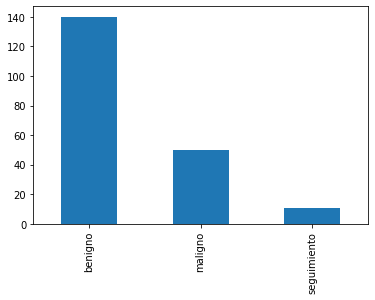

In [12]:
df_INbreast['Bi-Rads'].value_counts().plot(kind = 'bar')

In [13]:
 df_INbreast['Bi-Rads'].value_counts()

benigno        140
maligno         50
seguimiento     11
Name: Bi-Rads, dtype: int64

In [14]:
# def preprocess_image(image, target_size):
#     return cv2.resize(image, (target_size, target_size))

# size_img = 512  # Adjust based on your actual image size
# df_INbreast['MLO'] = df_INbreast['MLO'].apply(lambda img: preprocess_image(img, size_img))


In [15]:
# total_elements = X_train.size
# expected_elements = X_train.shape[0] * expected_features
# print("Total elements in X_train:", total_elements)
# print("Expected total elements:", expected_elements)

# # Check if reshape is feasible
# if total_elements == expected_elements:
#     X_train = X_train.reshape(X_train.shape[0], expected_features)
#     print("Reshaped X_train shape:", X_train.shape)
# else:
#     print("Reshape not possible due to mismatched element count.")
#     # Additional debugging steps:
#     print("Inspecting first element shape:", X_train[0].shape)
#     print("Inspecting first element:", X_train[0])
#     # You may want to inspect more elements or the data preparation steps


In [16]:
# X_train = np.array(df_INbreast['MLO'].tolist())
# print("Original shape:", X_train.shape)

# # Assuming size_img is correctly defined
# size_img = 512
# expected_features = 3 * size_img ** 2
# print("Expected features per sample:", expected_features)

# # Verify the total number of elements
# total_elements = X_train.size
# expected_elements = X_train.shape[0] * expected_features
# print("Total elements in X_train:", total_elements)
# print("Expected total elements:", expected_elements)

# # Check if reshape is feasible
# if total_elements == expected_elements:
#     X_train = X_train.reshape(X_train.shape[0], expected_features)
# else:
#     print("Reshape not possible due to mismatched element count.")

In [17]:
# unique, counts = np.unique(y_train, return_counts = True)
# strategy = {0:counts.max(), 1:counts.max(), 2:counts.max()}
# smote = SMOTE(sampling_strategy = strategy)
# X_smote, y_smote = smote.fit_resample(X_train, y_train)
# X_smote = X_smote.reshape(X_smote.shape[0], size_img, size_img, 3)

In [18]:

# visualize(X_smote[-6])

In [19]:

print(pd.__version__)


1.3.5


# Data Augmentation

In [20]:
def vertFlip(img):
    """
    Applies a vertical flip to the image
        - img is the input image
    Returns:
        - vflip_img is the vertical flipped image
    """
    transform = A.VerticalFlip(p = 1)
    vflip_img = transform(image = img)['image']
    
    return vflip_img

<Axes: >

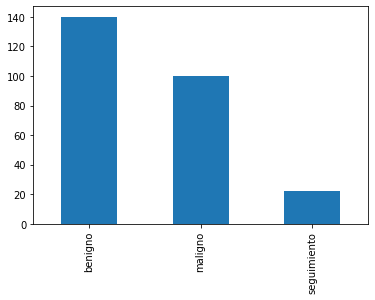

In [21]:
for index, row in df_INbreast.iterrows():
    if row['Bi-Rads'] != 'benigno':
        new_row = pd.DataFrame([[(row['Bi-Rads']), (row['Case ID'] + '_Flip'), vertFlip(row['CC Image']), vertFlip(row['MLO Image'])]], 
                               columns = list(df_INbreast.columns))
        df_INbreast = df_INbreast.append(new_row, ignore_index = True)
    
df_INbreast['Bi-Rads'].value_counts().plot(kind = 'bar')

In [22]:
 df_INbreast['Bi-Rads'].value_counts()

benigno        140
maligno        100
seguimiento     22
Name: Bi-Rads, dtype: int64

In [23]:
df_INbreast

,Bi-Rads,Case ID,CC Image,MLO Image
0,benigno,61b13c59bcba149e_201001_R_benigno,"[[[87, 87, 87], [87, 87, 87], [87, 87, 87], [8...","[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9..."
1,seguimiento,61b13c59bcba149e_201001_L_seguimiento,"[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9...","[[[103, 103, 103], [103, 103, 103], [103, 103,..."
2,maligno,6bd24a0a42c19ce1_201001_R_maligno,"[[[96, 96, 96], [96, 96, 96], [96, 96, 96], [9...","[[[100, 100, 100], [100, 100, 100], [100, 100,..."
3,benigno,6bd24a0a42c19ce1_201001_L_benigno,"[[[102, 102, 102], [102, 102, 102], [102, 102,...","[[[93, 93, 93], [93, 93, 93], [93, 93, 93], [9..."
4,benigno,97ec8cadfca70d32_201001_L_benigno,"[[[111, 111, 111], [111, 111, 111], [111, 111,...","[[[94, 94, 94], [94, 94, 94], [94, 94, 94], [9..."
...,...,...,...,...
257,maligno,fe7d005dcbbfb46d_201001_R_maligno_Flip,"[[[103, 103, 103], [103, 103, 103], [103, 103,...","[[[92, 92, 92], [92, 92, 92], [92, 92, 92], [9..."
258,maligno,cc9e66c5b31baab8_200901_R_maligno_Flip,"[[[93, 93, 93], [93, 93, 93], [93, 93, 93], [9...","[[[98, 98, 98], [98, 98, 98], [98, 98, 98], [9..."
259,seguimiento,8dbbd4e51f549ff0_200902_R_seguimiento_Flip,"[[[112, 112, 112], [112, 112, 112], [112, 112,...","[[[93, 93, 93], [93, 93, 93], [93, 93, 93], [9..."
260,maligno,6200187f3f1ccc18_201001_L_maligno_Flip,"[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9...","[[[82, 82, 82], [82, 82, 82], [82, 82, 82], [8..."


In [25]:
df_INbreast['Bi-Rads'].unique()

array(['benigno', 'seguimiento', 'maligno'], dtype=object)

# Almacenamiento de datos en el fichero externo

In [26]:

df_INbreast = df_INbreast.set_index('Case ID', drop = True)
df_INbreast.head()

,Bi-Rads,CC Image,MLO Image
Case ID,,,
61b13c59bcba149e_201001_R_benigno,benigno,"[[[87, 87, 87], [87, 87, 87], [87, 87, 87], [8...","[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9..."
61b13c59bcba149e_201001_L_seguimiento,seguimiento,"[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9...","[[[103, 103, 103], [103, 103, 103], [103, 103,..."
6bd24a0a42c19ce1_201001_R_maligno,maligno,"[[[96, 96, 96], [96, 96, 96], [96, 96, 96], [9...","[[[100, 100, 100], [100, 100, 100], [100, 100,..."
6bd24a0a42c19ce1_201001_L_benigno,benigno,"[[[102, 102, 102], [102, 102, 102], [102, 102,...","[[[93, 93, 93], [93, 93, 93], [93, 93, 93], [9..."
97ec8cadfca70d32_201001_L_benigno,benigno,"[[[111, 111, 111], [111, 111, 111], [111, 111,...","[[[94, 94, 94], [94, 94, 94], [94, 94, 94], [9..."


In [27]:

df_INbreast.to_pickle('./df_INbreast.pkl', protocol=4)

# Visualización del resultado final

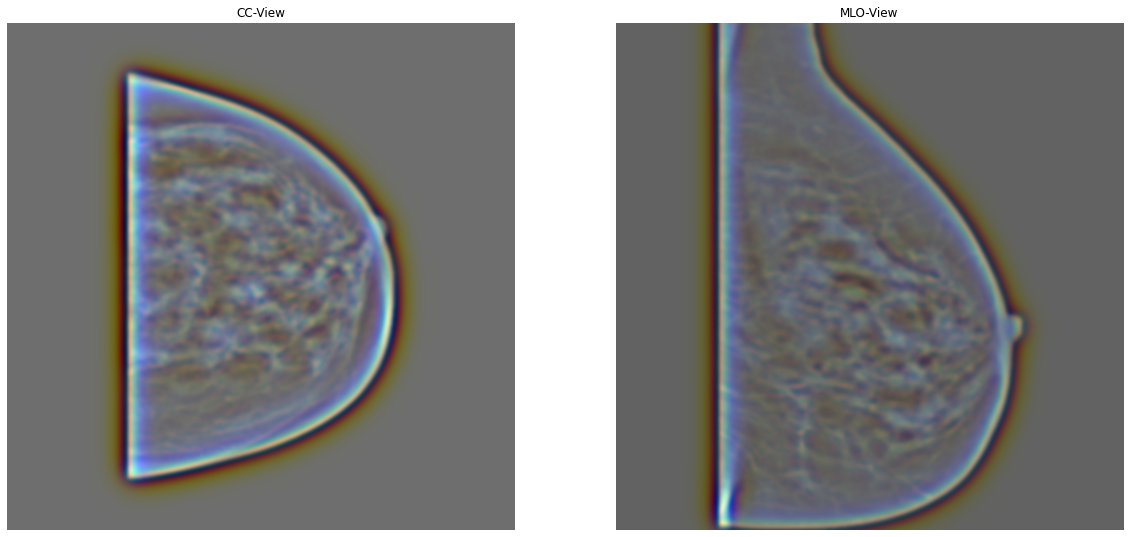

In [28]:
fig = plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('CC-View')
plt.imshow(df_INbreast['CC Image'][22])
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('MLO-View')
plt.imshow(df_INbreast['MLO Image'][22])
plt.show()